# Monet Style Image Generation - GAN

This is for the [Kaggle Competition](https://www.kaggle.com/competitions/gan-getting-started).

### Overview

This notebook implements a CycleGAN-style approach for translating photos into Monet-style paintings. The goal is to train a generator that can convert real photos into images with Monet-like characteristics and a discriminator that distinguishes generated images from real Monet paintings.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import PIL
import random
import math
import torchsummary

from tqdm import tqdm
import shutil

from pathlib import Path

# Image Plot

In [3]:
def plot_sample_imgs(pathes: list[Path], title: str) -> None:
    rows = 3
    cols = 10
    plt.subplots(rows, cols, figsize=(cols, rows))
    for i, image_path in enumerate(pathes[:rows * cols]):
        img = PIL.Image.open(image_path)
        PIL.ImageDraw.Draw(img)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title)

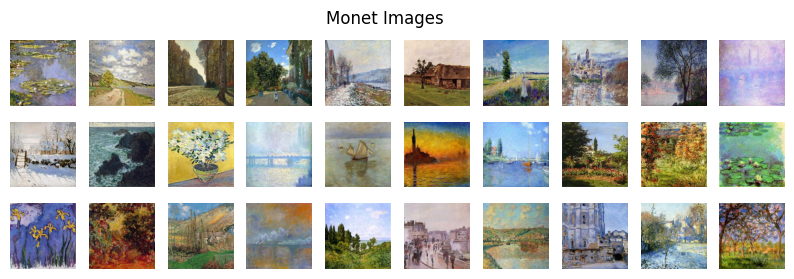

In [4]:
monet_path = Path('/kaggle/input/gan-getting-started/') / 'monet_jpg'
plot_sample_imgs(list(monet_path.iterdir()), "Monet Images")

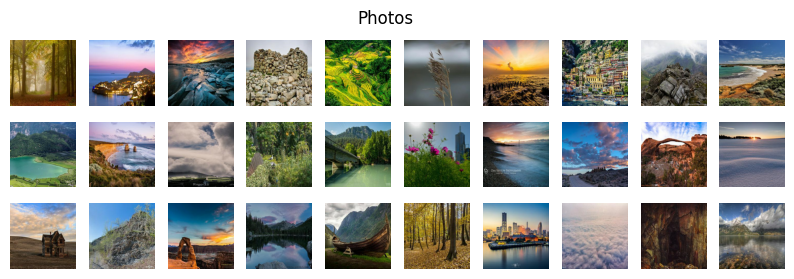

In [5]:
photo_path = Path('/kaggle/input/gan-getting-started/') / 'photo_jpg'
plot_sample_imgs(list(photo_path.iterdir()), "Photos")

# Dataset & DataLoader

- Monet images from the Kaggle competition: `monet_jpg`
- Real photos from the Kaggle competition: `photo_jpg`
- Dataset is wrapped by the `MonetPhoto` Dataset class which pairs Monet and Photo images and applies common transforms (resize, random flip, normalize).

In [6]:
class MonetPhoto(Dataset):
    def __init__(self, transform=None, size:int = math.inf):
        self.data_root = Path('/kaggle/input/gan-getting-started/')
        
        self.monet_path = self.data_root / 'monet_jpg'
        self.monet_images = list(self.monet_path.iterdir())
        random.shuffle(self.monet_images)
        
        self.photo_path = self.data_root / 'photo_jpg'
        self.photo_images = list(self.photo_path.iterdir())
        random.shuffle(self.photo_images)

        self.transform = transform
        self.size = size

    def __len__(self):
        return min(
            max(len(self.monet_images), len(self.photo_images)), 
            self.size
        )

    def __getitem__(self, i):
        monet_image = PIL.Image.open(self.monet_images[i % len(self.monet_images)])
        photo_image = PIL.Image.open(self.photo_images[i % len(self.photo_images)])
        if self.transform:
            monet_image = self.transform(monet_image)
            photo_image = self.transform(photo_image)
        return monet_image, photo_image

### Data normalization / denormalization
- Input transforms: Resize to (256,256), RandomHorizontalFlip(p=0.3), ToTensor(), Normalize(0.5, 0.5).
  - Note: `Normalize(0.5, 0.5)` implies the code expects mean=0.5 and std=0.5 for each channel so pixel values in [0,1] are shifted to approximately [-1, 1].
- When saving images: denormalize via: `img = img * 0.5 + 0.5` then multiply by 255 and cast to uint8 for saving as JPEG/PNG.


In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomHorizontalFlip(p=0.3),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

dataset = MonetPhoto(transform=transforms)

In [8]:
len(dataset)

7038

In [9]:
x, y = dataset.__getitem__(1)
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [10]:
x.max(), x.min(), y.max(), y.min()

(tensor(0.9451), tensor(-1.), tensor(1.), tensor(-1.))

In [11]:
training_data, testing_data = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(training_data.dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(testing_data.dataset, batch_size=32, shuffle=True, num_workers=2)

# Modeling


### Model architecture (detailed)

Below is a layer-by-layer description of the two main networks used in this notebook. The code defines building blocks (`DownBlock`, `UpBlock`, `CNNBlock`) that are composed to form the generator and discriminator. The model Architecture is referencing [Cycle GAN](https://www.kaggle.com/code/tahmidmir/this-cyclegan-is-somwhat-of-a-painter-itself)

Generator (U-Net / encoder-decoder with skip connections):
- Input: 3x256x256 image (RGB, normalized to range [-1, 1]).
- initial_down: Conv2d(in=3, out=64, kernel=4, stride=2, padding=1, padding_mode='reflect') + LeakyReLU  -> 64x128x128
- down1: DownBlock(64 -> 128): Conv2d(64,128,4,2,1,padding_mode='reflect') + BatchNorm + LeakyReLU -> 128x64x64
- down2: DownBlock(128 -> 256) -> 256x32x32
- down3: DownBlock(256 -> 512) -> 512x16x16
- down4: DownBlock(512 -> 512) -> 512x8x8
- down5: DownBlock(512 -> 512) -> 512x4x4
- down6: DownBlock(512 -> 512) -> 512x2x2
- bottleneck: Conv2d(512,512,4,2,1,padding_mode='reflect') + ReLU -> 512x1x1
- up blocks: a sequence of ConvTranspose2d + BatchNorm + ReLU (some with dropout) that progressively upsample back to 256x256. Each up block concatenates the corresponding down-skip feature maps (U-Net skip connections).
- final: ConvTranspose2d(128 -> 3, kernel=4, stride=2, padding=1) + Tanh -> outputs in [-1, 1].

Discriminator (PatchGAN-style):
- Input: 3x256x256 image
- initial: Conv2d(3 -> 64, kernel=4, stride=2, padding=1) + LeakyReLU -> 64x128x128
- sequence of CNNBlock layers progressively reduce spatial size and increase channels: 128, 256, 512 (with stride=1 on the last block) -> produces a patch-level score map
- final Conv2d to 1 channel outputs a map of logits that represent real/fake on overlapping patches (PatchGAN).

### Loss terms and training strategy (current notebook)
- The current trainer uses Least-Squares GAN style MSE loss applied to discriminator and generator outputs:
  - D_loss = MSE(D(real), 1) + MSE(D(fake), 0)
  - G_loss = MSE(D(G(x)), 1)
- A simplification: both generator and discriminator parameters are passed into a single Adam optimizer and the notebook updates both together per step. This works but is non-standard: generally you should use two optimizers (one for G and one for D) and alternate updates or apply different step frequencies.

### Training approach
- The `GANTrainer` coordinates training and validation loops, optimization, logging, and checkpointing.
- Losses used: mean-squared error (MSE) for generator and discriminator (basic GAN objective in LSGAN-style).
- Optimizer: Adam with a single optimizer updating both generator and discriminator parameters together (this is a simplification).

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        return self.conv(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
        
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'
            )
        )
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, tensor_in):
        return self.model(self.initial(tensor_in))

In [15]:
class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, use_dropout: bool=False):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        
        self.conv = nn.Sequential(*layers)
    
    def forward(self, tensor_in):
        return self.conv(tensor_in)

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, use_dropout: bool=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        
        self.conv = nn.Sequential(*layers)
    
    def forward(self, tensor_in):
        return self.conv(tensor_in)

# CycleGAN Generator

In [16]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        ) #128
        
        self.down1 = DownBlock(features, features*2)   #64
        self.down2 = DownBlock(features*2, features*4) #32
        self.down3 = DownBlock(features*4, features*8) #16
        self.down4 = DownBlock(features*8, features*8) #8
        self.down5 = DownBlock(features*8, features*8) #4
        self.down6 = DownBlock(features*8, features*8) #2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode='reflect'), #1x1
            nn.ReLU(),
        )
        self.up1 = UpBlock(features*8, features*8, use_dropout=True)
        self.up2 = UpBlock(features*8 + features*8, features*8, use_dropout=True)
        self.up3 = UpBlock(features*8 + features*8, features*8, use_dropout=True)
        self.up4 = UpBlock(features*8 + features*8, features*8)
        self.up5 = UpBlock(features*8 + features*8, features*4)
        self.up6 = UpBlock(features*4 + features*4, features*2)
        self.up7 = UpBlock(features*2 + features*2, features)
        self.finil_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        down1 = self.initial_down(x)
        down2 = self.down1(down1)
        down3 = self.down2(down2)
        down4 = self.down3(down3)
        down5 = self.down4(down4)
        down6 = self.down5(down5)
        down7 = self.down6(down6)
        
        bottleneck = self.bottleneck(down7)
        
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, down7], 1))
        up3 = self.up3(torch.cat([up2, down6], 1))
        up4 = self.up4(torch.cat([up3, down5], 1))
        up5 = self.up5(torch.cat([up4, down4], 1))
        up6 = self.up6(torch.cat([up5, down3], 1))
        up7 = self.up7(torch.cat([up6, down2], 1))
        
        return self.finil_up(torch.cat([up7, down1], 1))

# Training

In [29]:
class GANTrainer:
    def __init__(
        self,
        train_data: DataLoader,
        val_data: DataLoader,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        model_save_path: Path | None = None,
        nb_epochs: int = 5,
        lr:float=3e-4,
    ):
        self.train_data = train_data
        self.val_data = val_data
        self.generator = generator
        self.discriminator = discriminator
        self.nb_epochs = nb_epochs
        self.generator_save_path = model_save_path / "generator.pt"
        self.discriminator_save_path = model_save_path / "discriminator.pt"
        
        self.optimizer = torch.optim.Adam(
            [
                {"params": self.generator.parameters(), "lr": lr}, 
                {"params": self.discriminator.parameters(), "lr": lr},
            ]
        )

        self.logs = {
            "Step": [],
            "Train_g_loss": [],
            "Train_d_loss": [],
            "Val_g_loss": [],
            "Val_d_loss": [],
        }
        
    def train(self):
        best_score = torch.inf

        for i in range(self.nb_epochs):
            train_d_loss, train_g_loss, val_d_loss, val_g_loss = 0, 0, 0, 0
            self.generator.train()
            self.discriminator.train()
            # Train loop
            progress_bar = tqdm(
                enumerate(self.train_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} train",
                leave=False,
                total=len(self.train_data),
            )
            for step, (x, y) in progress_bar:
                x = x.to(device)
                y = y.to(device)

                # Train step
                g_loss, d_loss = self.train_step(x, y)

                train_g_loss += g_loss
                train_d_loss += d_loss

                progress_bar.set_postfix_str(
                    f"g_loss: {train_g_loss / (step + 1) :.2f}, d_loss: {train_d_loss / (step + 1) :.2f}"
                )

            # Validation loop
            self.generator.eval()
            self.discriminator.eval()

            progress_bar = tqdm(
                enumerate(self.val_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} validation",
                leave=True,
                total=len(self.val_data),
            )
            for step, (x, y) in progress_bar:
                x = x.to(device)
                y = y.to(device)

                # Validation step
                g_loss, d_loss = self.val_step(x, y)

                val_g_loss += g_loss
                val_d_loss += d_loss

                progress_bar.set_postfix_str(
                    f"g_loss: {val_g_loss / (step + 1) :.2f} d_loss: {val_d_loss / (step + 1) :.2f}"
                )

            # Saving best model
            if self.generator_save_path and best_score > val_g_loss:
                best_score = val_g_loss
                self.save_model()

            # Log
            self.log_metrics(
                step=i,
                train_g_loss=train_g_loss,
                train_d_loss=train_d_loss,
                val_g_loss=val_g_loss,
                val_d_loss=val_d_loss,
            )
            
        return self.logs

    def train_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor
    ) -> tuple:
        self.optimizer.zero_grad(set_to_none=True)
        
        fake_ = self.discriminator(self.generator(x))
        real = self.discriminator(y)
        d_loss = (
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=device)) + 
            torch.nn.functional.mse_loss(fake_, torch.zeros_like(fake_, device=device))
        )
        d_loss.backward()
        
        fake = self.discriminator(
            self.generator(x)
        )
        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=device))
        g_loss.backward()
        
        self.optimizer.step()

        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def val_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> tuple:
        fake = self.discriminator(
            self.generator(x)
        )
        real = self.discriminator(y)
        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=device))
        d_loss = (
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=device)) + 
            torch.nn.functional.mse_loss(fake, torch.zeros_like(fake, device=device))
        )
        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def log_metrics(
        self,
        step: int,
        train_g_loss: torch.Tensor,
        train_d_loss: torch.Tensor,
        val_g_loss: torch.Tensor,
        val_d_loss: torch.Tensor,
    ):
        self.logs["Step"].append(step)
        self.logs["Train_g_loss"].append(train_g_loss / len(self.train_data))
        self.logs["Train_d_loss"].append(train_d_loss / len(self.train_data))
        self.logs["Val_g_loss"].append(val_g_loss / len(self.val_data))
        self.logs["Val_d_loss"].append(val_d_loss / len(self.val_data))

    def save_model(self):
        if self.generator_save_path:
            torch.save(
                self.generator.state_dict(),
                self.generator_save_path,
            )
            torch.save(
                self.discriminator.state_dict(),
                self.discriminator_save_path,
            )

    def load_model(self):
        if self.generator_save_path and self.generator_save_path.is_file():
            self.generator.load_state_dict(
                torch.load(self.generator_save_path, weights_only=False)
            )
            self.discriminator.load_state_dict(
                torch.load(self.discriminator_save_path, weights_only=False)
            )

In [30]:
CHECKPOINT_PATH = Path("./checkpoint")
CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)

trainer = GANTrainer(
    train_data = train_dataloader,
    val_data = test_dataloader,
    generator = Generator(in_channels=3, features=64).to(device=device),
    discriminator = Discriminator().to(device=device),
    model_save_path = CHECKPOINT_PATH,
    nb_epochs = 5,
)

# Let's see those photos

In [31]:
trainer.load_model()

In [32]:
logs = trainer.train()

Epoch 5/5 validation: 100%|██████████| 220/220 [00:34<00:00,  6.31it/s, g_loss: 0.13 d_loss: 0.56]


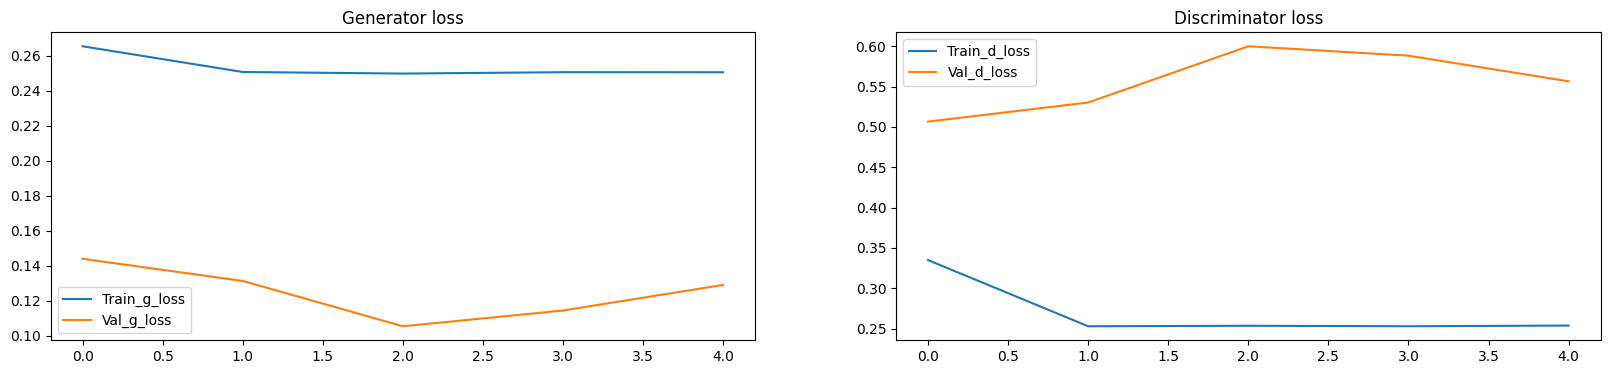

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(logs["Step"], logs["Train_g_loss"], label="Train_g_loss")
ax[1].plot(logs["Step"], logs["Train_d_loss"], label="Train_d_loss")
ax[0].plot(logs["Step"], logs["Val_g_loss"], label="Val_g_loss")
ax[1].plot(logs["Step"], logs["Val_d_loss"], label="Val_d_loss")
ax[0].set_title("Generator loss")
ax[1].set_title("Discriminator loss")
ax[0].legend()
ax[1].legend()
plt.show()

### Try the Model

In [34]:
mones, photos = next(iter(train_dataloader))

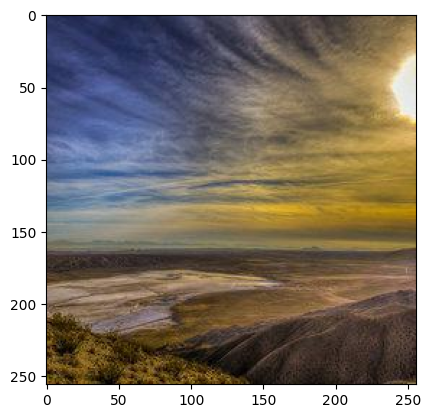

In [35]:
plt.imshow(photos[1].permute(1, 2, 0).numpy() * 0.5 + 0.5)

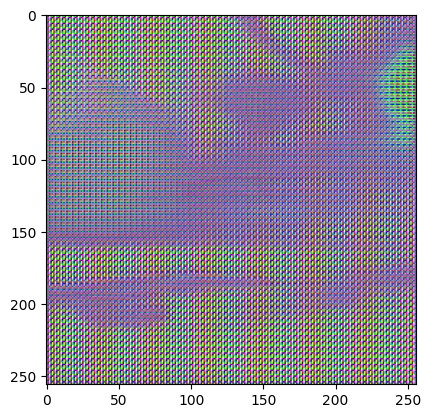

In [36]:
fake_img = trainer.generator((photos[1].unsqueeze(0)).to('cuda'))
fake_img = fake_img[0].cpu().detach()
plt.imshow(fake_img.permute(1, 2, 0).numpy() * 0.5 + 0.5  )

# Submission

In [37]:
Path("../images").mkdir(exist_ok=True, parents=True)

In [38]:
with torch.no_grad():
    for i, (_,img) in enumerate(DataLoader(dataset, batch_size=1, shuffle=False)):
        prediction = trainer.generator(img.to(device))[0].cpu().permute(1, 2, 0).numpy()* 0.5 + 0.5
        im = PIL.Image.fromarray((prediction * 255).astype(np.uint8))
        im.save("../images/" + str(i) + ".jpg")

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

### Next steps / Suggestions

1. Implement cycle-consistency loss and identity loss to match the CycleGAN paper (this will significantly improve style transfer quality).
1. Use separate optimizers for generator and discriminator and consider updating D more frequently than G or vice versa depending on training stability.
1. Save example images per epoch and a small HTML or markdown gallery to visualize progress during training.
1. Add Scheduler and try train for more epoches.